In [2]:
# load model
from patch.models.gpt2 import GPT2, create_gpt2

config, tokenizer, gpt = create_gpt2()
model = GPT2(config, gpt, verbose=False)

loaded model


In [3]:
model.model.num_parameters()

124439808

In [4]:
from patch.utils import embed_to_distrib, top_vals, format_token

inputs = [
    tokenizer("The capital of Spain is", return_tensors="pt"),
    tokenizer("The capital of Italy is", return_tensors="pt")
]
print(inputs)

res, cache = model(inputs, lambda x: 0, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
res, cache = model(inputs, lambda x: 1, lambda x: False, store_cache=False)
distrib = embed_to_distrib(model, res.hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

[{'input_ids': tensor([[ 464, 3139,  286, 8602,  318]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}, {'input_ids': tensor([[ 464, 3139,  286, 8031,  318]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}]
_Madrid              0.10501430183649063
_the                 0.09496448934078217
_Barcelona           0.07027824968099594
_a                   0.04010051116347313
_now                 0.028243739157915115
_in                  0.02759999968111515
_Spain               0.022992147132754326
_Catalonia           0.01882328651845455
_also                0.018689345568418503
_not                 0.017356840893626213

_Rome                0.15734398365020752
_the                 0.07316114008426666
_Milan               0.046880945563316345
_a                   0.03450039029121399
_now                 0.032002970576286316
_in                  0.023064950481057167
_also                0.022747935727238655
_home                0.019203385338187218
_not                 0.016405237838625908
_Ital

In [6]:
import pandas as pd
from tqdm import tqdm
from functools import partial

layers = config.n_layer
nodes = ["none"]
for l in range(layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')

def per_node_and_position(which, branch):
    tokens = tokenizer.encode(" Madrid Rome")
    data = []
    
    for i, node in enumerate(tqdm(nodes)):
        for j in range(len(inputs[0].input_ids[0])):
            model.cache = {}
            res, cache = model(
                inputs,
                partial(which, node=node, pos=j),
                partial(branch, node=node, pos=j),
                store_cache=True
            )
            distrib = embed_to_distrib(model, res.hidden_states, logits=False)
            for token in tokens:
                data.append({
                    'token': format_token(tokenizer, token),
                    'prob': float(distrib[0][-1][token]),
                    'layer': node,
                    'pos': j,
                    'id': i
                })

    df = pd.DataFrame(data)
    return df

In [7]:
# for this node and position, scrub
def which(path, node, pos):
    if f"{node}.head.pos{pos}" in path or f"{node}.pos{pos}" in path:
        return 1
    return 0

# control branching to only expose positions at the node in question
def branch(path, node, pos):
    if path[-1] == f'{node}': return 'positions'
    if path[-1] == f'{node}.head': return 'positions'
    return False

df = per_node_and_position(which, branch)

100%|██████████| 25/25 [00:05<00:00,  4.31it/s]


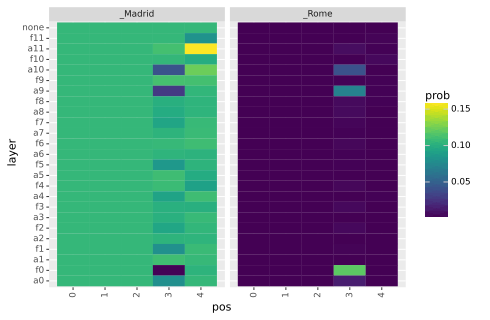

In [8]:
%config InlineBackend.figure_formats = ['svg']

from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text

df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: last_token.svg


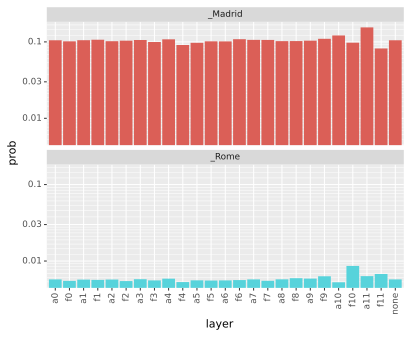

In [9]:
from plotnine import geom_bar, facet_wrap, geom_hline, scale_y_log10, theme

# filtered = df[df['token']=='_Madrid']
filtered = df
filtered = filtered[filtered['pos'] == 4]
# filtered = filtered[~filtered['layer'].str.startswith('f')]
# true = float(filtered[filtered['layer'] == "none"]['prob'])
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none') + scale_y_log10()
         + facet_wrap("~token", ncol=1))
g.save('last_token.svg')
print(g)

In [14]:
filtered[filtered['token'] == '_Rome'].set_index('layer')['prob']

layer
none    0.005747
f11     0.006762
a11     0.006337
f10     0.008625
a10     0.005277
f9      0.006316
a9      0.005882
f8      0.005954
a8      0.005754
f7      0.005508
a7      0.005749
f6      0.005638
a6      0.005575
f5      0.005551
a5      0.005588
f4      0.005308
a4      0.005874
f3      0.005578
a3      0.005785
f2      0.005462
a2      0.005725
f1      0.005668
a1      0.005714
f0      0.005500
a0      0.005747
Name: prob, dtype: float64

In [18]:
import pandas as pd
from tqdm import tqdm
from IPython import display

layers = config.n_layer
nodes = ["none"]
for l in range(layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')

tokens = tokenizer.encode(" Madrid Rome")
data = []
model.cache = {}
for i, node in enumerate(tqdm(nodes)):
    for j in range(len(inputs[0].input_ids[0])):
        def which(path):
            res = len([x for x in path if x.endswith(f'pos{j}')])
            return 1 if res >= 1 else 0

        def branch(path):
            for nod in nodes[:i + 1]:
                if path[-1] == nod and len(path) == 2: return 'positions'
                if path[-1] == f'{nod}.head' and len(path) == 3: return 'positions'
            return False

        res, cache = model(inputs, which, branch, store_cache=True)
        # dot = res.visualise_path()
        # display.display_svg(dot)
        # input()
        distrib = embed_to_distrib(model, res.hidden_states, logits=False)
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': node,
                'pos': j,
                'id': i
            })

df = pd.DataFrame(data)
df[:5]

100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


,token,prob,layer,pos,id
0,_Madrid,0.105014,none,0,0
1,_Rome,0.005747,none,0,0
2,_Madrid,0.105014,none,1,0
3,_Rome,0.005747,none,1,0
4,_Madrid,0.105014,none,2,0


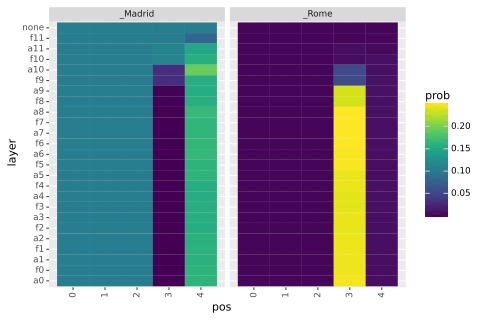

In [19]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
df['layer'] = df['layer'].cat.set_categories(nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/aryamanarora/opt/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: last_token.svg


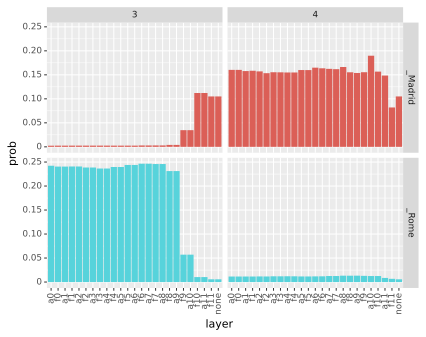

In [20]:
from plotnine import geom_bar, facet_grid, geom_hline, scale_y_log10, theme

# filtered = df[df['token']=='_Madrid']
filtered = df
filtered = filtered[filtered['pos'] >= 3]
# filtered = filtered[~filtered['layer'].str.startswith('f')]
# true = float(filtered[filtered['layer'] == "none"]['prob'])
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none')
         + facet_grid("token~pos"))
g.save('last_token.svg')
print(g)